In [1]:
pip install gdown jcopml eli5 git+https://github.com/MeMartijn/updated-sklearn-crfsuite.git 

  Cloning https://github.com/MeMartijn/updated-sklearn-crfsuite.git to /tmp/pip-req-build-d42fsxzi
  Running command git clone --filter=blob:none --quiet https://github.com/MeMartijn/updated-sklearn-crfsuite.git /tmp/pip-req-build-d42fsxzi
  Resolved https://github.com/MeMartijn/updated-sklearn-crfsuite.git to commit 675038761b4405f04691a83339d04903790e2b95
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.9 MB/s eta 0:00:00
  Created wheel for jcopml: filename=jcopml-1.2.7-py2.py3-none-any.whl size=45917 sha256=aede4cf23949deb2063d79be3b599ae73e7f8765d768a3c199185a8337af7239
  Stored in directory: /root/.cache/pip/wheels/1b/f0/69/8cd4944dd9637953ab744056b5faa32617cd4de449b213e886
  Created wheel for sklearn-crfsuite: filename=sklearn_crfsuite-0.3.6-py2.py3-none-any.whl size=10866 sha256=a57708cc6ae26cb01c166e725c6a072c92f0157b7526e9b4b58f4b810bd745

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score
from jcopml.plot import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import joblib
import gdown
from functools import wraps
import sklearn_crfsuite
from sklearn_crfsuite.utils import flatten
from sklearn_crfsuite import scorers

In [4]:
file_id = '1-GhEOfug-V5KbvESx3ZzQOxQ8x0HIZrG'
output = 'data.csv'  
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-GhEOfug-V5KbvESx3ZzQOxQ8x0HIZrG
To: /kaggle/working/data.csv
100%|██████████| 44.4M/44.4M [00:00<00:00, 73.3MB/s]


'data.csv'

In [5]:
df = pd.read_csv(output)
df = df.fillna('')
docs_to_drop = ['doc:601', 'doc:602']
df = df[~df['doc'].isin(docs_to_drop)]
df

,doc,fragment,token,label,pos
0,doc:1,fragment:1,PUTUSAN,O,PROPN
1,doc:1,fragment:1,Nomor,O,PROPN
2,doc:1,fragment:1,48,B_VERN,NUM
3,doc:1,fragment:1,/,I_VERN,PUNCT
4,doc:1,fragment:1,Pid,I_VERN,PROPN
...,...,...,...,...,...
1245820,doc:600,fragment:11272,.,O,PUNCT
1245821,doc:600,fragment:11272,Panitera,O,PROPN
1245822,doc:600,fragment:11272,Pengganti,O,PROPN
1245823,doc:600,fragment:11272,",",B_REGI,PUNCT


# CRF

In [6]:
class FragmentGetter(object):

    def __init__(self, data):
        self.n_frag = 1
        self.data = data
        self.empty = False
        agg_func = lambda f: [(t, p, l) for t, p, l in 
                              zip(f['token'].values.tolist(),
                                  f['pos'].values.tolist(),
                                  f['label'].values.tolist())]
        self.grouped = self.data.groupby('fragment').apply(agg_func)
        self.fragments = [f for f in self.grouped]

    def get_next(self):
        try:
            f = self.grouped['Fragment: {}'.format(self.n_frag)]
            self.n_frag += 1
            return f
        except:
            return None

In [7]:
def token2features(frag, i):
    token = frag[i][0]
    postag = frag[i][1]

    features = {
        'bias': 1.0,
        'token':token,
        'token.lower()': token.lower(),
        'token.isupper()': token.isupper(),
        'token.istitle()': token.istitle(),
        'token.isdigit()': token.isdigit(),
        'postag': postag,
    }

    # Features for previous token
    if i > 0:
        features.update({
            'prev1': frag[i-1][0],
            'prev1.lower()': frag[i-1][0].lower(),
            'prev1.isupper()': frag[i-1][0].isupper(),
            'prev1.istitle()': frag[i-1][0].istitle(),
            'prev1.isdigit()': frag[i-1][0].isdigit(),
            'prev1.postag': frag[i-1][1],
        })
    else:
        features['BOF'] = True  # Beginning of fragment

    if i > 1:
        features.update({
            'prev2': frag[i-2][0],
            'prev2.lower()': frag[i-2][0].lower(),
            'prev2.isupper()': frag[i-2][0].isupper(),
            'prev2.istitle()': frag[i-2][0].istitle(),
            'prev2.isdigit()': frag[i-2][0].isdigit(),
            'prev2.postag': frag[i-2][1],
        })

    # Features for next token
    if i < len(frag) - 1:
        features.update({
            'next1': frag[i+1][0],
            'next1.lower()': frag[i+1][0].lower(),
            'next1.isupper()': frag[i+1][0].isupper(),
            'next1.istitle()': frag[i+1][0].istitle(),
            'next1.isdigit()': frag[i+1][0].isdigit(),
            'next1.postag': frag[i+1][1],
        })
    else:
        features['EOF'] = True  # End of fragment

    if i < len(frag) - 2:
        features.update({
            'next2': frag[i+2][0],
            'next2.lower()': frag[i+2][0].lower(),
            'next2.isupper()': frag[i+2][0].isupper(),
            'next2.istitle()': frag[i+2][0].istitle(),
            'next2.isdigit()': frag[i+2][0].isdigit(),
            'next2.postag': frag[i+2][1],
        })

    return features

def frag2features(frag):
  return [token2features(frag, i) for i in range(len(frag))]
def frag2labels(frag):
  return [label for token, postag, label in frag]

In [8]:
X_crf = df.drop(['doc'], axis=1)
getter = FragmentGetter(X_crf)
fragments = getter.fragments

X = [frag2features(f) for f in fragments]
y = [frag2labels(f) for f in fragments]

In [9]:
# Daftar unik dokumen
docs = df['doc'].unique().tolist()

# Menentukan batas dokumen terakhir untuk training (70% dari total dokumen)
train_doc_count = int(len(docs) * 0.7)
train_docs = docs[:train_doc_count]

# Mencari fragment terakhir dari data train
train_df = df[df['doc'].isin(train_docs)]
id_last_frag = train_df['fragment'].unique().tolist()[-1]
last_frag = int(id_last_frag.split(':')[1])

# Memotong data menjadi training dan testing set berdasarkan indeks terakhir
X_train = X[:last_frag+1]
y_train = y[:last_frag+1]
X_test = X[last_frag+1:]
y_test = y[last_frag+1:]

# Menampilkan hasil pemisahan data
print(f"Jumlah sampel dalam training set: {len(X_train)}")
print(f"Jumlah sampel dalam testing set: {len(X_test)}")

Jumlah sampel dalam training set: 7985
Jumlah sampel dalam testing set: 3287


In [10]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf_start = time.time()
crf.fit(X_train, y_train)
crf_end = time.time()
print(f'{(crf_end - crf_start):.2f} Detik.')

725.11 Detik.


In [11]:
joblib.dump(crf, '600crf_pos_prevnext_wordfrom.pkl')

['600crf_pos_prevnext_wordfrom.pkl']

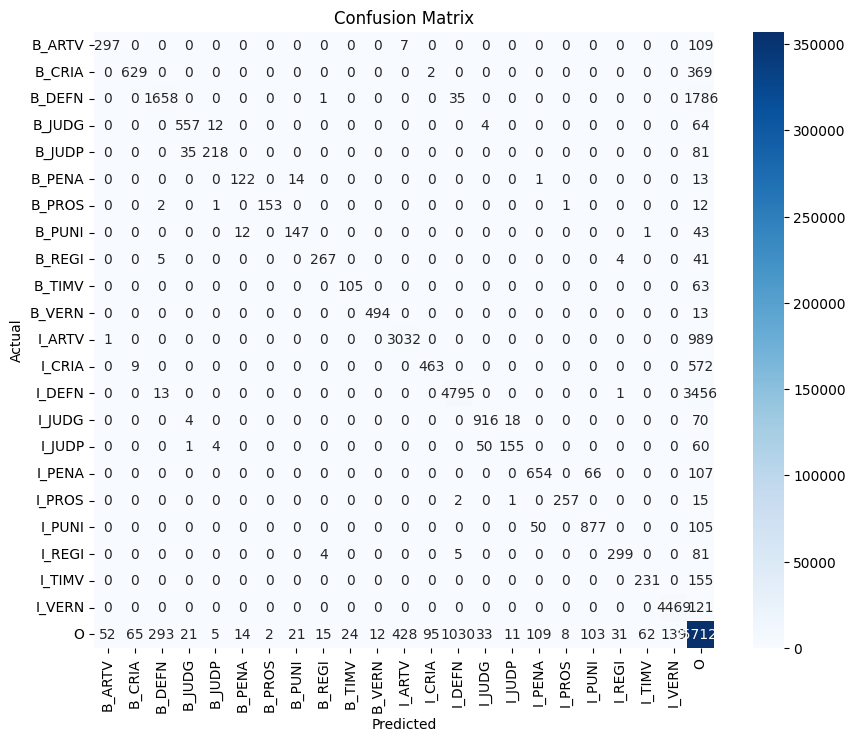

              precision    recall  f1-score   support

      B_ARTV       0.85      0.72      0.78       413
      B_CRIA       0.89      0.63      0.74      1000
      B_DEFN       0.84      0.48      0.61      3480
      B_JUDG       0.90      0.87      0.89       637
      B_JUDP       0.91      0.65      0.76       334
      B_PENA       0.82      0.81      0.82       150
      B_PROS       0.99      0.91      0.94       169
      B_PUNI       0.81      0.72      0.76       203
      B_REGI       0.93      0.84      0.88       317
      B_TIMV       0.81      0.62      0.71       168
      B_VERN       0.98      0.97      0.98       507
      I_ARTV       0.87      0.75      0.81      4022
      I_CRIA       0.83      0.44      0.58      1044
      I_DEFN       0.82      0.58      0.68      8265
      I_JUDG       0.91      0.91      0.91      1008
      I_JUDP       0.84      0.57      0.68       270
      I_PENA       0.80      0.79      0.80       827
      I_PROS       0.97    

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred= crf.predict(X_test)
y_test_flat = [label for sent in y_test for label in sent]
y_pred_flat = [label for sent in y_pred for label in sent]

# change label to list
y = df.label.values
classes = np.unique(y)
classes = classes.tolist()

# Buat confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_flat, labels=classes)

# Visualisasikan confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test_flat, y_pred_flat, labels=classes))

In [13]:
import eli5
eli5.show_weights(crf, top=15)

2024-07-11 20:46:02.867536: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 20:46:02.867675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 20:46:03.036392: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


From \ To,B_ARTV,B_CRIA,B_DEFN,B_JUDG,B_JUDP,B_PENA,B_PROS,B_PUNI,B_REGI,B_TIMV,B_VERN,I_ARTV,I_CRIA,I_DEFN,I_JUDG,I_JUDP,I_PENA,I_PROS,I_PUNI,I_REGI,I_TIMV,I_VERN,O
B_ARTV,-3.467,-0.245,0.0,0.0,0.0,-0.28,0.0,-0.914,0.0,-0.079,-0.477,1.071,-2.082,-1.389,-0.271,-0.26,-0.809,-0.117,-0.864,0.0,-1.498,-0.407,-3.275
B_CRIA,-0.184,-2.356,-0.525,0.0,0.0,0.0,0.0,-0.577,0.0,0.0,0.0,-1.854,1.512,-2.055,-0.598,-0.836,-1.045,-0.384,-1.555,-0.449,-1.499,-0.713,-0.579
B_DEFN,-0.448,-0.717,-2.224,-0.133,0.0,0.0,0.0,0.0,-0.024,0.0,0.0,-2.351,-2.753,2.522,-1.443,-0.953,-1.213,-0.906,-1.19,-1.257,-1.748,-1.503,-0.541
B_JUDG,0.0,0.0,-0.64,-1.657,-1.044,0.0,0.0,0.0,-0.85,0.0,0.0,-1.261,-1.751,-2.609,3.636,-2.863,-0.597,-1.507,-0.709,-1.717,-0.746,-1.447,-2.01
B_JUDP,0.0,0.0,-0.385,-1.44,-1.618,0.0,0.0,0.0,-0.403,0.0,0.0,-1.322,-1.317,-2.502,-3.474,3.334,-0.669,-1.564,-0.681,-1.641,-0.474,-1.4,-1.752
B_PENA,0.0,0.0,0.0,0.0,0.0,-0.002,0.0,-0.372,0.0,0.0,0.0,-0.843,-0.516,-0.54,0.0,0.0,3.135,0.0,-3.248,0.0,-0.755,-0.401,-2.065
B_PROS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.31,-0.653,-0.45,-0.781,-1.696,-0.155,4.939,0.0,-1.034,-0.298,-0.467,-0.245
B_PUNI,0.0,-0.11,0.0,0.0,0.0,-0.267,0.0,-0.263,0.0,0.0,0.0,-0.763,-1.393,-1.116,-0.115,0.0,-4.016,0.0,2.453,0.0,-0.791,-1.205,-2.913
B_REGI,0.0,0.0,-0.207,-0.615,-0.451,0.0,0.0,0.0,-1.96,0.0,0.0,-1.194,-1.213,-2.302,-2.235,-1.375,-0.366,-1.448,-0.393,4.321,-0.761,-0.621,-0.541
B_TIMV,-0.39,-0.116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.205,-1.21,-0.944,-0.379,-0.152,-1.889,0.0,-1.736,0.0,1.315,-1.138,-2.97
